# Generating Text with an RNN

In [2]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [5]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [6]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

France hath in thee found out
A nest of hollow bosoms, which he fills
With treacherous crowns; and three corrupted men,
One, Richard Earl of Cambridge, and the second,
Henry Lord Scroop of Masham, and 


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [7]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [8]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [9]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [10]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [11]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [12]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    batch_size, length = input.shape
    
    hidden_start = rnn.init_hidden(batch_size, device)
    hidden = hidden_start
    
    running_loss = torch.zeros((1)).to(device)
    optimizer.zero_grad()
    for i in range(length):
        
        curr_input = input[:,i]
        curr_target = target[:,i]
        output, hidden = rnn(curr_input, hidden)
        
        running_loss += criterion(output.view(batch_size, -1), curr_target.view(batch_size))
        
    running_loss /= length
    running_loss.backward()
    optimizer.step()
    loss = running_loss.data.cpu().numpy()[0]
    ##########       END      ##########

    return loss


In [12]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 32s (50 1%) train loss: 2.1005, test_loss: 2.1139]
Whe lord well of wlot the ingle thou my for af yerthire! You it man not the on shenest this rut her pu 

 4s (100 2%) train loss: 1.9514, test_loss: 1.9704]
Why, mine indich what song.
I with rive and is are mun
Marined fors,
Of the in ever.

BAONO:
Nout of G 

 35s (150 3%) train loss: 1.8797, test_loss: 1.8857]
Whight,
Be coulds
Nowes
So the comblet of this, gort
thou out in tell me?

PENCENTIO:
In a dead, I the 

 6s (200 4%) train loss: 1.8303, test_loss: 1.8304]
When made, what like min;
'Thee, I'll ness thee your mait seaving at thus therey nike whou of may that 

 37s (250 5%) train loss: 1.7663, test_loss: 1.8151]
What reat of capuner, like thee rout had a vill Cast my faint from not you wich me bouns the purpost t 

 9s (300 6%) train loss: 1.7488, test_loss: 1.7952]
What vore thou up leftles, fere
And he dection see the brentle, you affes,
Warwind. I kind, all entent 

 40s (350 7%) train loss: 1.

 49s (2600 52%) train loss: 1.6365, test_loss: 1.7339]
Why, be he to my trut and the jogh your pleame him is men more!

OILINE:
I come; like out on go, not I 

 18s (2650 53%) train loss: 1.6625, test_loss: 1.7180]
Whing hid to hath a bidout glain? my prains for in the restain and that that we and at seet go not
I a 

 47s (2700 54%) train loss: 1.6350, test_loss: 1.7239]
Whingle his strokes Trook me
and an hold his hand,
I'll wish a lotkinger. But be that last pripes. The 

 16s (2750 55%) train loss: 1.6133, test_loss: 1.7001]
Whip the true too rest was heart looks?

ROSALIND:
I cut so a peace and ear a sool for is natuel me
I  

 46s (2800 56%) train loss: 1.6522, test_loss: 1.7164]
What thy war we thanks to much, and I have the monest-chate do to more more
In wantle and no away this 

 15s (2850 56%) train loss: 1.6421, test_loss: 1.6993]
Wher have bune.

FLORENCE:
If I would away.

ULYSSES:
Come, sare life, thou had unto the repons, and m 

 44s (2900 57%) train loss: 1.6495, test

In [ ]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

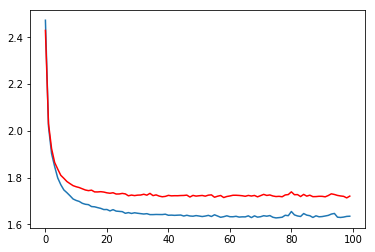

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [14]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

This made bloody my come, with him.

CAPULEN:
I will perse.

QUEEN KATHOM:
Then so slection have I would he shall be had my plentend
Stomest meanius soldiers, we wall the word, and,
By my brearring answear'd again, seet thou word.

FORD PEDRLENTRUCHIO:
What grack fare! I would 'too stands,
Doubt the lest prince with the padend'd with my right; which not more; and you shall shorted rite, sir, My ear never go, garst
That though not a sad their sense, would your
lordance;
And then land so no, those way head, you would must the vousicer! I'll mean
What done; and it love king, and should doth prisord of seater'd in somether here upon the poor not a great the trumber, but so, and I must that you seeks fortune is what brow the rather or heaven My gewselford: and Antony on a perfend come on hath againds, sir, nor.

Varrow be fanst you there battord then is soldier's:
It had we should does. The child as it The so, for come no most was the well utters, tances this good our deserate: thy most was

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.

Training for 5000 epochs...
 30s (50 1%) train loss: 2.0808, test_loss: 2.0933]
Whe hearl to mable, shast,
Is and I'll a him not HRENES:
Ind the ceick the the love the coveres but le 

 4s (100 2%) train loss: 1.8741, test_loss: 1.9157]
Wh. KING, Vill and miticion, he sore suce, sing unjreped.

PROSSalust dewemle fold me! Rome.

CIO:
I k 

 36s (150 3%) train loss: 1.7974, test_loss: 1.8242]
Who cunger, and poop was and hows dor a bear
diebbin thy loves with thou sell,' think in are so,
the l 

 7s (200 4%) train loss: 1.7523, test_loss: 1.7793]
Whit in farit,
And name you toching of what was thee at this curage; strase for what we newer
Of the p 

 40s (250 5%) train loss: 1.6657, test_loss: 1.7294]
Wheir man, not for wittest.

ARCES:
Nay, told you spend to a shough had be strimpance,
There is the me 

 15s (300 6%) train loss: 1.6692, test_loss: 1.7290]
Wh, the child to my
his long;
But I am have it did my sarker shall ether contience
That sake of the op 

 46s (350 7%) train loss: 1

 31s (2600 52%) train loss: 1.5097, test_loss: 1.6321]
When here we'll the burn his own
The hand my moin uttrazed for the seate before to
master more and so, 

 4s (2650 53%) train loss: 1.5092, test_loss: 1.6657]
What shall not on,
hunty? soul use strake your fair the new,
The must against your wise for,
And thou  

 33s (2700 54%) train loss: 1.5152, test_loss: 1.6264]
Who do et compascumish the
him the vain: and the king.

DON JOHNE:
And in man, get the current to the  

 2s (2750 55%) train loss: 1.5271, test_loss: 1.6085]
What in an enoug
The father's doine of the court's bold,
Or tell men, accurs and be mustables.

PRINCE 

 31s (2800 56%) train loss: 1.5059, test_loss: 1.6169]
Who defent than he she.

PORTIUS:
Give you thy widder case us of my haste,
Who once the Moulth thildin 

 59s (2850 56%) train loss: 1.5276, test_loss: 1.6429]
Why son of the prouddless.
'Tis fair days: thou have 'tis hand some is myself,
To the king it here the 

 28s (2900 57%) train loss: 1.5261, test_l

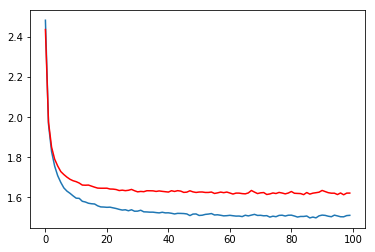

In [12]:
### GRU

rnn = RNN(n_characters, hidden_size, n_characters, model_type="gru", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

In [12]:
### LSTM

rnn = RNN(n_characters, hidden_size, n_characters, model_type="lstm", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

Training for 5000 epochs...
torch.Size([1, 100, 100]) torch.Size([1, 100, 100])


RuntimeError: Expected hidden[0] size (1, 100, 100), got (100, 100)

Training for 5000 epochs...
 29s (50 1%) train loss: 2.4862, test_loss: 2.4599]
Wh thage areme sst ore th, ine coin ant reld th hes cond areatey sow war, han mt the thnt! ill and o l 

 58s (100 2%) train loss: 2.2256, test_loss: 2.2606]
Whave and roat hist end reas yount an gous spow mon and, the, rave toan io aty mall chill fond ich hy  

 27s (150 3%) train loss: 2.1028, test_loss: 2.1391]
Whou hime groused whall brontand it will angis in sill of than the wing the your herither all and mall 

 56s (200 4%) train loss: 2.0417, test_loss: 2.0269]
Whince to come me best that a the am, as wird 'brais the puster!
He whill that and river?

CHOR SODAT: 

 25s (250 5%) train loss: 1.9640, test_loss: 1.9913]
Whou are afe ol count hensed so to on her with me live!
A ney are Dot; will devin sear there, midenoul 

 54s (300 6%) train loss: 1.9591, test_loss: 1.9526]
Whold suchon de farme to shad of eever are suardich is and courner
sugy this thear not chall: which me 

 24s (350 7%) train loss:

 17s (2600 52%) train loss: 1.6351, test_loss: 1.7332]
What,
Thou handy bit Dend:
Wholish he pronem's sent we have duke and glay that hath resent to Engendat 

 47s (2650 53%) train loss: 1.6257, test_loss: 1.6786]
Why love with his lenger the darcing which not to poory in my hand. I lord, sir, and part your humble  

 16s (2700 54%) train loss: 1.6254, test_loss: 1.6924]
When the takery close now, by so starvess;
and the help.

TROILUS:
Sald to be valation you stay hest i 

 45s (2750 55%) train loss: 1.6564, test_loss: 1.6977]
Whing not and Acood?

First Gentleman:
I have not breacts;
Herilelous my thing no men shall with his t 

 15s (2800 56%) train loss: 1.6230, test_loss: 1.7140]
What is the payio of the sigger,
I'll sent lives and indeed but old and mover'd from the can heart the 

 45s (2850 56%) train loss: 1.6486, test_loss: 1.6934]
When you are no more to the boy, or the word to hang ring hath deewing.

MALTHO:
Marder,
Park of frien 

 14s (2900 57%) train loss: 1.6098, test

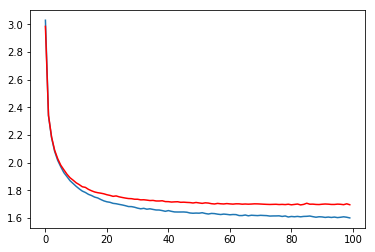

In [12]:
### RNN

learning_rate=0.002

rnn = RNN(n_characters, hidden_size, n_characters, model_type="rnn", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

Training for 5000 epochs...
 34s (50 1%) train loss: 1.9963, test_loss: 2.0105]
Whey agald thet heing hese
'listuous Delle tors not I all thou seave and thym in the dear is furefortu 

 8s (100 2%) train loss: 1.8134, test_loss: 1.8189]
Whe dimed thou, for, and with thou here me, sens his poothing I was and sugind hat, me sovent; an so t 

 42s (150 3%) train loss: 1.7045, test_loss: 1.7275]
Who hour for he be the dunch!

TIMON:
All be done sill not was no scarted a caster contlid? I latwise  

 16s (200 4%) train loss: 1.6514, test_loss: 1.6782]
Whick of him shall so queasing you my lime to the hand!

THALLOV:
What seed by sore
So again it course 

 50s (250 5%) train loss: 1.5920, test_loss: 1.6651]
When Servanting than my will make of their will dispacesty be me like done and mind that itself, and n 

 24s (300 6%) train loss: 1.5648, test_loss: 1.6263]
Who, fagent more unclates and preward, they for greath in meit there's the blood,
You have hast the gr 

 57s (350 7%) train loss: 

 13s (2600 52%) train loss: 1.3697, test_loss: 1.4821]
Whose worfoll? what will countance of his force of and flatter me,
Too fair more than from their
purfe 

 47s (2650 53%) train loss: 1.3489, test_loss: 1.4686]
What sayest me with day with the match
With servants, which he can do so true, what away: which, I war 

 21s (2700 54%) train loss: 1.3643, test_loss: 1.4944]
What you still as war his friend
Upon'tish.

ROSENCRANTZ:
Good my lord, best from Maided, and every ma 

 56s (2750 55%) train loss: 1.3461, test_loss: 1.4883]
What yet first stand against him? what, arrusy the rest is conchoration thou be well be consul-heathle 

 32s (2800 56%) train loss: 1.3785, test_loss: 1.4602]
Whereus packets,
That many way, is purse is to the more subjects, rite of the last
Thou hast thee lear 

 6s (2850 56%) train loss: 1.3664, test_loss: 1.4912]
Which we are frost of royal grace time makes revenge, here comes thee, shall, my lord.

KING HENRY SOL 

 40s (2900 57%) train loss: 1.3751, test_

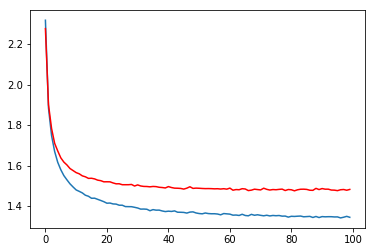

In [13]:
### GRU

hidden_size = 400
learning_rate = 0.003


rnn = RNN(n_characters, hidden_size, n_characters, model_type="rnn", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))

Training for 5000 epochs...
 37s (50 1%) train loss: 2.0647, test_loss: 2.0756]
What from the hith there come bere greatiend, sors, many afone
To so, as ue wort you heart ming me the 

 14s (100 2%) train loss: 1.8467, test_loss: 1.8766]
What preir
in wall must of that his
menter you the spover fry firth to will so the not of the with a s 

 51s (150 3%) train loss: 1.7059, test_loss: 1.7423]
Who ejendes a hell but they you for if, holl sprest own be they have death:
Me mode to to I have bold  

 29s (200 4%) train loss: 1.6332, test_loss: 1.6622]
Who shall may came so breatid.

LONINIUS:
As, an underord and lave their to the tongue.

JULIA:
I will 

 6s (250 5%) train loss: 1.5637, test_loss: 1.5967]
Who, marry remian duke you, strange me: and my mother:
And keep to affess of the Dare you.

FORD:
What 

 43s (300 6%) train loss: 1.5238, test_loss: 1.5654]
Where die of the rake, sir.
'Tis think I'll give you stands of
like her stones, to rescands free secur 

 20s (350 7%) train loss: 

 11s (2600 52%) train loss: 1.2850, test_loss: 1.4216]
What say you the man bring our constable;
I am sure;
And, to speak and be so loathsome squares and the 

 49s (2650 53%) train loss: 1.2843, test_loss: 1.4260]
Which 'there to invite our death of it,
When he woods ready,
His worthy of his grief, I should not nig 

 26s (2700 54%) train loss: 1.2882, test_loss: 1.3962]
What is mine, I never shun him comfort.

CASCA:
'Tis foul is too ladies that I was
A traitival of his
 

 3s (2750 55%) train loss: 1.2750, test_loss: 1.4206]
Who loves away.

First Servingman:
What is your guilty;
You do weep.

CLARENCE:
Be between your knee D 

 40s (2800 56%) train loss: 1.3067, test_loss: 1.4621]
What I know not of the maiden bawd, let thee another superse, theiring wanteth into thy mind in his st 

 18s (2850 56%) train loss: 1.3061, test_loss: 1.4228]
What comest before I'll come.

PORTIA:
Now, brother, will all that thou art not much what till he sast 

 55s (2900 57%) train loss: 1.2834, test_

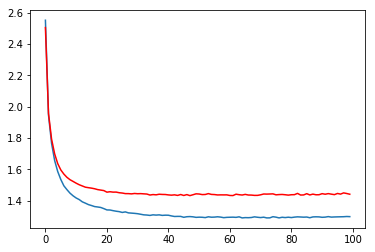

In [14]:
### RNN
n_layers=3

rnn = RNN(n_characters, hidden_size, n_characters, model_type="rnn", n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

print(evaluate(rnn, prime_str='Th', predict_len=1000))